### Week 3 notebook

Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 3, include concepts such as linear regression with forward and backward selection, PCR, and PLSR. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

# data preprocesing and scoring
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error

random_state = 0

In [2]:
# encode categorical features
def encode_categories(df: pd.DataFrame):
    df_encoded = df.copy()
    mappings = {}
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        # get the unique categories (in order of appearance)
        uniques = df_encoded[col].dropna().unique().tolist()
        # build a mapping: category -> code
        mapping = {cat: code for code, cat in enumerate(uniques)}
        mappings[col] = mapping

        # map (leave NaN as NaN)
        df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

    return df_encoded, mappings

In [3]:
# Create a function to load and split data
def load_and_split_data(file_path, test_size=0.2, random_state=0):

    # Read and Encode catigorical features
    df, _ = encode_categories(pd.read_csv(file_path))

    # Feature and target
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    #Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled features back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df


### Model Funcitons

In [4]:
X_train_car, X_test_car, y_train_car, y_test_car, df_car = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv')

In [5]:
# Forward Feature Selection
def forward_feature_selection(X_train, y_train):
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=5, n_jobs=-1)
    sfs.fit(X_train, y_train)
    selected_features = X_train.columns[sfs.get_support()]
    X_train_selected = X_train[selected_features]
    return X_train_selected, selected_features

In [6]:
# Forward Feature Selection
def backward_feature_selection(X_train, y_train):
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', cv=5, n_jobs=-1)
    sfs.fit(X_train, y_train)
    selected_features = X_train.columns[sfs.get_support()]
    X_train_selected = X_train[selected_features]
    return X_train_selected, selected_features

In [7]:
def lin_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"Root Mean Squared Error: {rmse:.4f}")
    return model, y_pred, rmse

In [8]:
def pca_or_plsr(X_train, y_train, X_test, y_test, components=2, choice='pca'):
    if choice == 'plsr':
        model = PLSRegression(n_components=components)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        print(f"Root Mean Squared Error w/ PLS: {rmse:.4f}")
        return model, y_pred, rmse
    else:    
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.fit_transform(X_test)
        model = LinearRegression()
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        rmse = root_mean_squared_error(y_test, y_pred)
        print(f"Root Mean Squared Error w/ PCA: {rmse:.4f}")
        return model, y_pred, rmse

### Car Claims dataset

In [9]:
# Create a baseline model for the car claims dataset
model_car_baseline, y_pred_car_baseline, car_baseline_rmse = lin_regression(X_train_car, y_train_car, X_test_car, y_test_car)

Root Mean Squared Error: 0.2274


In [10]:
# Forward Selection on Car Claims dataset
X_car_forward, car_forward_features = forward_feature_selection(X_train_car, y_train_car)
model_car_forward, y_pred_car_forward, car_forward_rmse = lin_regression(X_car_forward, y_train_car, X_test_car[X_car_forward.columns], y_test_car)

Root Mean Squared Error: 0.2275


In [11]:
# Backward Selection on Car Claims dataset
X_car_backward, car_backward_features = backward_feature_selection(X_train_car, y_train_car)
model_car_backward, y_pred_car_backward, car_backward_rmse = lin_regression(X_car_backward, y_train_car, X_test_car[X_car_backward.columns], y_test_car)

Root Mean Squared Error: 0.2275


In [12]:
# Principal Components Regression on car_claims dataset
model_car_pca, y_pred_car_pca, car_pca_rmse = pca_or_plsr(X_train_car, y_train_car, X_test_car, y_test_car, components=5, choice='pca')

Root Mean Squared Error w/ PCA: 0.2338


In [13]:
# Partial Least Squares Regression on car_claims dataset
model_car_plsr, y_pred_car_plsr, car_plsr_rmse = pca_or_plsr(X_train_car, y_train_car, X_test_car, y_test_car, components=5, choice='plsr')

Root Mean Squared Error w/ PLS: 0.2274


In [14]:
# Store the results in a dataframe
results_car = pd.DataFrame({
    'model': ['Baseline', 'Forward Selection', 'Backward Selection', 'PCA', 'PLSR'],
    'rmse': [car_baseline_rmse, car_forward_rmse, car_backward_rmse, car_pca_rmse, car_plsr_rmse]
})

### Insurance Claims dataset

In [15]:
X_train_ins, X_test_ins, y_train_ins, y_test_ins, df_ins = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv')

In [16]:
# Create a baseline model for the Insurance Claims dataset dataset
model_ins_baseline, y_pred_ins_baseline, ins_baseline_rmse = lin_regression(X_train_ins, y_train_ins, X_test_ins, y_test_ins)

Root Mean Squared Error: 0.4170


In [17]:
# Forward Selection on Insurance Claims dataset
X_ins_forward, ins_forward_features = forward_feature_selection(X_train_ins, y_train_ins)
model_ins_forward, y_pred_ins_forward, ins_forward_rmse = lin_regression(X_ins_forward, y_train_ins, X_test_ins[X_ins_forward.columns], y_test_ins)

Root Mean Squared Error: 0.4150


In [18]:
# Backward Selection on Insurance Claims dataset
X_ins_backward, ins_backward_features = backward_feature_selection(X_train_ins, y_train_ins)
model_ins_backward, y_pred_ins_backward, ins_backward_rmse = lin_regression(X_ins_backward, y_train_ins, X_test_ins[X_ins_backward.columns], y_test_ins)

Root Mean Squared Error: 0.4158


In [19]:
# Principal Components Regression on insurance claims dataset
model_ins_pca, y_pred_ins_pca, ins_pca_rmse = pca_or_plsr(X_train_ins, y_train_ins, X_test_ins, y_test_ins, components=5, choice='pca')

Root Mean Squared Error w/ PCA: 0.4459


In [20]:
# Partial Least Squares Regression on insurance claims dataset
model_ins_plsr, y_pred_ins_plsr, ins_plsr_rmse = pca_or_plsr(X_train_ins, y_train_ins, X_test_ins, y_test_ins, components=5, choice='plsr')

Root Mean Squared Error w/ PLS: 0.4166


In [21]:
# Store the results in a dataframe
results_ins = pd.DataFrame({
    'model': ['Baseline', 'Forward Selection', 'Backward Selection', 'PCA', 'PLSR'],
    'rmse': [ins_baseline_rmse, ins_forward_rmse, ins_backward_rmse, ins_pca_rmse, ins_plsr_rmse]
})

### Fast and Furious dataset

In [22]:
df_furious = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train.csv')
df_furious.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0


In [23]:
df_furious.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         1399 non-null   object 
 1   Insurance_company  1399 non-null   object 
 2   Cost_of_vehicle    1310 non-null   float64
 3   Min_coverage       1310 non-null   float64
 4   Expiry_date        1399 non-null   object 
 5   Max_coverage       1310 non-null   float64
 6   Condition          1399 non-null   int64  
 7   Amount             1388 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 87.6+ KB


In [24]:
df_furious.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1310.000000,1310.000000,1310.000000,1399.000000,1388.000000
mean,37454.274809,936.356870,11242.925160,0.929235,4117.144092
std,8921.428143,223.035704,7163.735952,0.256523,3151.516223
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,29800.000000,745.000000,7603.000000,1.000000,1641.750000
50%,37300.000000,932.500000,9678.000000,1.000000,4070.000000
75%,45175.000000,1129.375000,11703.000000,1.000000,6039.500000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


In [25]:
# drop na values from the dataset
null_rows = df_furious[df_furious.isna().any(axis=1)]
df_furious_cleaned = df_furious.dropna()

# create a separate dateframe for the image and condition columns
df_furious_cleaned = df_furious_cleaned.drop(columns=['Image_path'])

# Split the expiyed date into year, month, and day
df_furious_cleaned['Expiry_date'] = pd.to_datetime(df_furious_cleaned['Expiry_date'], errors='coerce')
df_furious_cleaned['Expiry_year'] = df_furious_cleaned['Expiry_date'].dt.year
df_furious_cleaned['Expiry_month'] = df_furious_cleaned['Expiry_date'].dt.month
df_furious_cleaned['Expiry_day'] = df_furious_cleaned['Expiry_date'].dt.day

# drop the original expiry date column
df_furious_cleaned = df_furious_cleaned.drop(columns=['Expiry_date'])

# Reorder the columns to have the target at the end
df_furious_cleaned = df_furious_cleaned[[col for col in df_furious_cleaned.columns if col != 'Amount'] + ['Amount']]

# export cleaned data to csv
df_furious_cleaned.to_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train_cleaned.csv', index=False)

In [26]:
X_train_fur, X_test_fur, y_train_fur, y_test_fur, df_fur = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train_cleaned.csv')

In [27]:
X_train_fur

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Expiry_year,Expiry_month,Expiry_day
0,0.645100,-1.260901,-1.260901,-0.646659,0.286716,0.936097,0.360534,0.730154
1,-0.937221,-1.428930,-1.428930,-0.698798,0.286716,1.402353,-0.757068,-1.157334
2,-0.620757,1.696396,1.696396,0.270993,0.286716,0.469842,-0.198267,1.673898
3,0.961565,-0.140713,-0.140713,-0.299064,0.286716,0.936097,0.081134,1.202026
4,0.961565,-0.678403,-0.678403,-0.465909,0.286716,-0.462669,-1.036468,-0.331558
...,...,...,...,...,...,...,...,...
1035,0.961565,1.147504,1.147504,0.100671,0.286716,-0.928924,-1.595269,1.673898
1036,0.328636,-0.521577,-0.521577,-0.417246,0.286716,0.003587,-0.757068,-0.685462
1037,1.594493,0.441785,0.441785,-0.118314,0.286716,0.003587,-0.477667,1.319994
1038,0.645100,-1.484939,-1.484939,-0.716178,0.286716,-1.395180,-1.036468,-1.747174


In [28]:
# create baseline regression model for furious dataset
model_fur_baseline, y_pred_fur_baseline, fur_baseline_rmse = lin_regression(X_train_fur, y_train_fur, X_test_fur, y_test_fur)

Root Mean Squared Error: 4253.0497


In [29]:
# forward selection on furious dataset
X_fur_forward, fur_forward_features = forward_feature_selection(X_train_fur, y_train_fur)
model_fur_forward, y_pred_fur_forward, fur_forward_rmse = lin_regression(X_fur_forward, y_train_fur, X_test_fur[X_fur_forward.columns], y_test_fur)

Root Mean Squared Error: 4247.0460


In [30]:
# backward selection on the furious dataset
X_fur_backward, fur_backward_features = backward_feature_selection(X_train_fur, y_train_fur)
model_fur_backward, y_pred_fur_backward, fur_backward_rmse = lin_regression(X_fur_backward, y_train_fur, X_test_fur[X_fur_backward.columns], y_test_fur)

Root Mean Squared Error: 4227.6983


In [31]:
# Principal Components Regression on fast furious and insured dataset
model_fur_pca, y_pred_fur_pca, fur_pca_rmse = pca_or_plsr(X_train_fur, y_train_fur, X_test_fur, y_test_fur, components=5, choice='pca')

Root Mean Squared Error w/ PCA: 4233.5825


In [32]:
# Partial Least Squares Regression on fast furious and insured dataset
model_fur_plsr, y_pred_fur_plsr, fur_plsr_rmse = pca_or_plsr(X_train_fur, y_train_fur, X_test_fur, y_test_fur, components=5, choice='plsr')

Root Mean Squared Error w/ PLS: 4253.2458


In [33]:
# Store the results in a dataframe
results_fur = pd.DataFrame({
    'model': ['Baseline', 'Forward Selection', 'Backward Selection', 'PCA', 'PLSR'],
    'rmse': [fur_baseline_rmse, fur_forward_rmse, fur_backward_rmse, fur_pca_rmse, fur_plsr_rmse]
})

### Visualize results

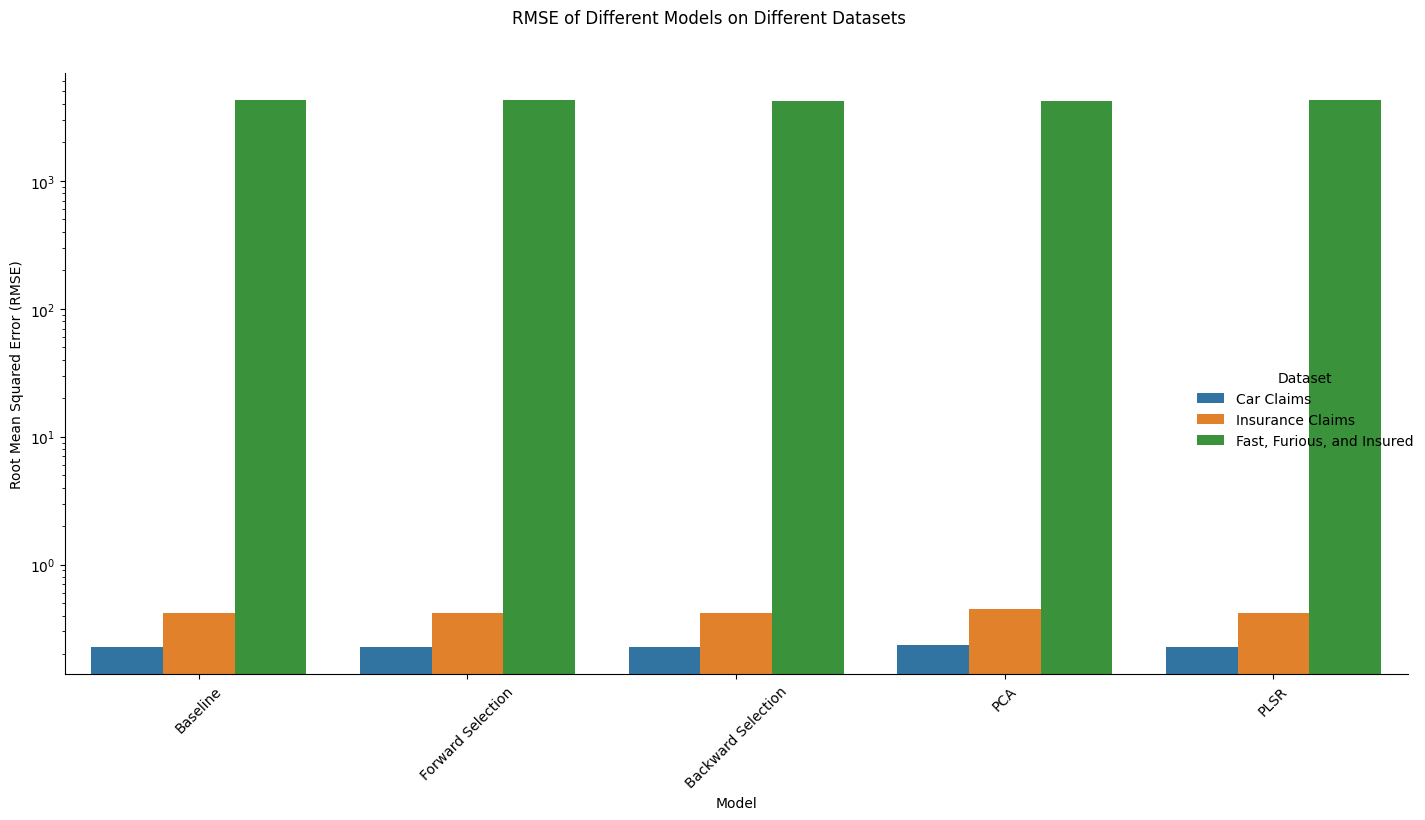

In [42]:
# Visualize the results
results_car['Dataset'] = 'Car Claims'
results_ins['Dataset'] = 'Insurance Claims'
results_fur['Dataset'] = 'Fast, Furious, and Insured'

results_all = pd.concat([results_car, results_ins, results_fur], ignore_index=True)

g = sns.catplot(
    data=results_all,
    x='model',
    y='rmse',
    hue='Dataset',
    kind='bar',
    height=8,
    aspect=1.5,
    dodge=True
)
g.fig.suptitle('RMSE of Different Models on Different Datasets', y=1.02)
g.set_axis_labels('Model', 'Root Mean Squared Error (RMSE)')
g.set_xticklabels(rotation=45)
g._legend.set_title('Dataset')

# Set y-axis to log scale
g.ax.set_yscale('log')

plt.tight_layout()
plt.show()